In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

Изначально импортируем необходимые библиотеки с прочитаем данные таблицы

In [3]:
data = pd.read_csv('train_dataset_train.csv')
data.head()

,id,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,time_to_under,label
0,1,40BD89EC85646EFB69E283F39C298E60,Пропуск FacePay,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-12 05:00:13,216.316667,8001
1,2,126727A96489CC976A8C08E5CEB00542,СК учащегося 30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:54,648.183333,9011
2,3,D28CE6A9E0E5B6D213470A97CFF32485,БСК дружинника г.Москвы,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:55,865.333333,7022
3,4,015DA44B523C062B5BFEFF3FB0E64B9E,30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:01:13,1048.233333,2022
4,5,95B19C6F3A504727AC3EA56EB7E3E80F,КОШЕЛЕК,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:02:55,965.600000,2017


In [4]:
data.describe(include='O')

,ticket_id,ticket_type_nm,entrance_nm,station_nm,line_nm,pass_dttm
count,1091021,1091021,1091021,1091021,1091021,1091021
unique,335533,60,426,245,16,297040
top,7992E92F9AE0F7506BD439547FD7E11F,КОШЕЛЕК,Щёлковская ( Северный ),Щёлковская,Таганско-Краснопресненская,2022-09-12 08:20:09
freq,8,262499,17810,22133,156031,29


Исходя из  общего описания таблицы, можно сделать вывод о том, что данные ticket_id не применимы в условиях решения нашей задачи. Также удалим дублирующие колонки.

In [5]:
data.drop(columns=['ticket_id','entrance_id','station_id','line_id','id'],inplace=True )


Выведем первые 5 строк таблицы

In [6]:
data.head()

,ticket_type_nm,entrance_nm,station_nm,line_nm,pass_dttm,time_to_under,label
0,Пропуск FacePay,Лефортово БКЛ,Лефортово,Большая кольцевая,2022-09-12 05:00:13,216.316667,8001
1,СК учащегося 30 дней,Войковская ( Южный ),Войковская,Замоскворецкая,2022-09-12 05:00:54,648.183333,9011
2,БСК дружинника г.Москвы,Войковская ( Южный ),Войковская,Замоскворецкая,2022-09-12 05:00:55,865.333333,7022
3,30 дней,Войковская ( Южный ),Войковская,Замоскворецкая,2022-09-12 05:01:13,1048.233333,2022
4,КОШЕЛЕК,Войковская ( Южный ),Войковская,Замоскворецкая,2022-09-12 05:02:55,965.600000,2017


Преобразуем колонку pass_dttm в дату и время

In [7]:
data.pass_dttm = pd.to_datetime(data.pass_dttm)

проверим есть ли незаполненные значения в таблице


In [8]:
data.isnull().sum()

ticket_type_nm    0
entrance_nm       0
station_nm        0
line_nm           0
pass_dttm         0
time_to_under     0
label             0
dtype: int64

Обработка таблицы закончена, приступим к задаче регрессии для предсказания времени следующей валидации

<AxesSubplot:>

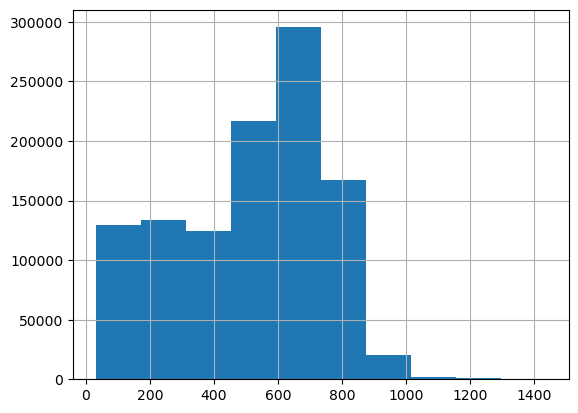

In [9]:
data['time_to_under'].hist()

Создадим функцию для приведения таблицы к единому виду:

In [10]:
def time_preprocess_r(data):
    data['day'] = data.pass_dttm.dt.dayofweek #день недели
    data['hour'] = data.pass_dttm.dt.hour # час в формате 24
    data['workday'] = data['day'].apply(lambda x: 0 if x == 5 or x == 6 else 1)
    data = data.drop(columns=['pass_dttm','entrance_nm','station_nm','line_nm','ticket_type_nm','label'])
    return data

In [11]:
time_preprocess_r(data)

,time_to_under,day,hour,workday
0,216.316667,0,5,1
1,648.183333,0,5,1
2,865.333333,0,5,1
3,1048.233333,0,5,1
4,965.600000,0,5,1
...,...,...,...,...
1091016,124.750000,0,2,1
1091017,56.066667,0,3,1
1091018,91.283333,0,3,1
1091019,47.900000,0,3,1


Далее предскажем время следующей валидации с помощью OLS

In [12]:

data = sm.add_constant(data)
x_regress_train, x_regress_test, y_regress_train, y_regress_test = train_test_split(data.drop(columns=['time_to_under']), data[['time_to_under']], test_size=0.3)
x_regress_train = time_preprocess_r(x_regress_train)
x_regress_test = time_preprocess_r(x_regress_test)

model_regression = sm.OLS(y_regress_train,x_regress_train)
model_regression=model_regression.fit()
forecast_regression= model_regression.predict(x_regress_test)

In [13]:
forecast_regression

99525      536.775578
671841      70.110594
295436     488.228275
1042699    407.475810
604262     574.575429
              ...    
410567     577.262292
814088     342.586369
149238     353.333820
234992     579.949154
1008586    545.057128
Length: 327307, dtype: float64

Далее решим задачу классификации:

In [15]:
def time_preprocess_c(data):
    data['day'] = data.pass_dttm.dt.dayofweek #день недели
   
    data['workday'] = data['day'].apply(lambda x: 0 if x == 5 or x == 6 else 1)

    data['name_workday'] = data['day'].apply(lambda x : 'holiday' if x == 5 or x ==6  else 'work')

    data = data.drop(columns=['pass_dttm','day','workday'])

    return data

In [16]:
time_preprocess_c(data)

,const,ticket_type_nm,entrance_nm,station_nm,line_nm,time_to_under,label,hour,name_workday
0,1.0,Пропуск FacePay,Лефортово БКЛ,Лефортово,Большая кольцевая,216.316667,8001,5,work
1,1.0,СК учащегося 30 дней,Войковская ( Южный ),Войковская,Замоскворецкая,648.183333,9011,5,work
2,1.0,БСК дружинника г.Москвы,Войковская ( Южный ),Войковская,Замоскворецкая,865.333333,7022,5,work
3,1.0,30 дней,Войковская ( Южный ),Войковская,Замоскворецкая,1048.233333,2022,5,work
4,1.0,КОШЕЛЕК,Войковская ( Южный ),Войковская,Замоскворецкая,965.600000,2017,5,work
...,...,...,...,...,...,...,...,...,...
1091016,1.0,Пропуск FacePay,Нижегородская (второй),Нижегородская,Некрасовская,124.750000,15005,2,work
1091017,1.0,Пропуск FacePay,Калужская (Северный),Калужская,Калужско-Рижская,56.066667,6007,3,work
1091018,1.0,Пропуск FacePay,Каширская (Северный ),Каширская,Замоскворецкая,91.283333,2010,3,work
1091019,1.0,Пропуск FacePay,Воронцовская (Первый),Воронцовская,Большая кольцевая,47.900000,11014,3,work


Возьмем для обучения 400 строк, создадим таблицу из этих значений, преобразуем к специальному виду и предскажем для 150 строк.

In [17]:
data.pass_dttm = pd.to_datetime(data.pass_dttm)


x_class_train = data.drop(columns=['label'])[:400]
y_class_train = data[['label']][:400]


test_class = data.loc[data.ticket_type_nm.isin(x_class_train.ticket_type_nm)&
                    data.entrance_nm.isin(x_class_train.entrance_nm) &
                    data.station_nm.isin(x_class_train.station_nm) &
                    data.line_nm.isin(x_class_train.line_nm) ]

x_class_test = test_class.drop(columns=['label'])[-150:]
y_class_test = test_class[['label']][-150:]

#x_class_train, x_class_test, y_class_train, y_class_test = train_test_split(data.drop(columns=['label']), data[['label']], test_size=0.4)

#x_class_train = time_preprocess_c(x_class_train)
#x_class_test = time_preprocess_c(x_class_test)


model_class = CatBoostClassifier(iterations = 10)
model_class.fit(x_class_train,y_class_train, cat_features=['name_workday','ticket_type_nm','entrance_nm','station_nm','line_nm'])
forecast_class= model_class.predict(x_class_test)


Learning rate set to 0.5
0:	learn: 5.0078844	total: 5.77s	remaining: 51.9s
1:	learn: 4.8507525	total: 11.1s	remaining: 44.5s
2:	learn: 4.7066361	total: 16.6s	remaining: 38.7s
3:	learn: 4.5686130	total: 22.6s	remaining: 33.9s
4:	learn: 4.4304104	total: 27.8s	remaining: 27.8s
5:	learn: 4.3763831	total: 33.6s	remaining: 22.4s
6:	learn: 4.2778591	total: 39.7s	remaining: 17s
7:	learn: 4.2050303	total: 45.7s	remaining: 11.4s
8:	learn: 4.0652821	total: 52.2s	remaining: 5.8s
9:	learn: 3.9543919	total: 58.3s	remaining: 0us


Расчитаем необходимые метрики

In [18]:
from sklearn.metrics import r2_score, recall_score
def result(actual_class, forecast_class, actual_regress, forecast_regress):
    print(r2_score(actual_regress, forecast_regress))
    print(recall_score(actual_class, forecast_class, average='micro'))
    return 0.5 * r2_score(actual_regress, forecast_regress) + 0.5 * recall_score(actual_class, forecast_class, average='micro')

In [19]:
print('result: ', result(y_class_test, forecast_class, y_regress_test, forecast_regression))

0.4623774135916435
0.006666666666666667
result:  0.2345220401291551
